In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
x = 0
delta = 0.1

# Functions required

In [3]:
def get_margins(mu, N, t, T):
    delta = 0.1
    val1 = 2*N/delta
    val2 = t**4
    val = val1*val2
    # print(val)
    log_term = math.log(val)
    sqrt_term = log_term/2/T
    alpha = math.sqrt(sqrt_term)
    LCB = mu - alpha
    UCB = mu + alpha
    return LCB, UCB

In [4]:
def get_feasible_set(mu_th, UCB_attr):
    ## mu_attr will be an array with the current means of all attributes of the specific arm
    ## same for UCB and LCB things
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    n = len(UCB_attr)
    m = len(UCB_attr[0])
    for i in range (n):
        ## for each arm
        found = False
        for j in range(m):
            if(UCB_attr[i][j] >= mu_th):
                found = True
                continue
            else:
                found = False
                break
        if (found == True):
            feasible_set.append(i)

    return feasible_set

In [5]:
def get_perfect_feasible_set(mu_th, LCB_attr, n):
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    # n = len(LCB_attr)
    m = len(LCB_attr[0])
    for i in range (n):
        ## for each arm
        found = False
        for j in range(m):
            if(LCB_attr[i][j] >= mu_th):
                found = True
                continue
            else:
                found = False
                break
        if (found == True):
            feasible_set.append(i)

    return feasible_set

In [6]:
def get_potential_set(i_star_t, LCB_i_star, UCB):
    ## here UCB will be an array for UCB of means of all the arms
    potent = []
    # print(LCB_i_star)
    # print(UCB)
    for i in range(len(UCB)):
        if ((LCB_i_star <= UCB[i]) and (i != i_star_t)):
        # if(LCB_i_star <= UCB[i]):
            potent.append(i)
    # print("potent", potent)
    return potent

In [7]:
def best_arm(mu, feasible_set):
    ## for arms in feasible set, we need to find the arm with maximum mean
    # print(feasible_set)
    best = feasible_set[0]
    for i in range (len(feasible_set)):
        if (mu[feasible_set[i]] > mu[best]):
            # print(feasible_set)
            best = feasible_set[i]

    return best

In [8]:
def intersection(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3

In [9]:
def potentially_competitor_arm(UCB, feasible_set, potentially_best_arm):
    # best = feasible_set[0]
    # print(UCB)
    if (potentially_best_arm != feasible_set[0]):
        best = feasible_set[0]
    else:
        best = feasible_set[1]
    # print(feasible_set[1])
    # print(best)
    for arm in feasible_set:
        if (arm != potentially_best_arm):
            if((UCB[arm] > UCB[best])):
                best = arm
    # print("pot: ", potentially_best_arm, "ct: ", best)
    return best

In [10]:
def get_suboptimal_arm(mu_i_star, mu_i, feasible_arms):
    suboptimal = []
    for arms in feasible_arms:
        if (mu_i[arms] < mu_i_star):
            suboptimal.append(arms)

    return suboptimal

In [11]:
def difference(li1, li2):
    s = set(li2)
    temp3 = [x for x in li1 if x not in s]
    return temp3

# Oracle

In [32]:
class Oracle:
    def __init__(self, M, N, mu_th) -> None:
        self.M = M
        self.N = N
        arms = 5
        attributes = 2
        self.mu_ij = [[0 for i in range (attributes)] for j in range (arms)]
        self.mu_i = [0 for i in range (arms)]

        ## we have N arms, each having M attributes
        self.mu_th = mu_th

        # #### Values #####
        self.var = 3
        self.mu_ij[0] = np.array([x, 8])          #16 to 24
        self.mu_ij[1] = np.array([4, 17])         #21
        self.mu_ij[2] = np.array([7, 8])          #15
        self.mu_ij[3] = np.array([4, 8])          #12
        self.mu_ij[4] = np.array([1, 7])          #8
        # #################

        for i in range (len(self.mu_i)):
            self.mu_i[i] = sum(self.mu_ij[i])   

    def play(self, arm):
        ## play arm mentioned and return rewards corresponding to each attribute
        reward = np.zeros(self.M)
        for j in range (len(reward)):
            reward[j] = np.random.normal(self.mu_ij[arm][j], self.var, 1)

        return reward
    
    def H_index(self):
        self.i_star = 0                 ## best arm in the feasible set
        self.i_star_star = 1            ## best arm in suboptimal set
        self.delta_i = [0 for i in range (self.N)]
        self.delta_ij = [[0 for i in range (self.M)] for j in range (self.N)]
        self.delta_i_attr = [0 for i in range (self.N)]

        ### assume that always i_star is 0 ###
        for i in range (1, self.N):
            self.delta_i[i] = self.mu_i[self.i_star] - self.mu_i[i]
            self.delta_ij[i] = abs(self.mu_ij[self.i_star] - self.mu_th)
            self.delta_i_attr[i] = min(self.delta_ij[i])

        self.delta_i[self.i_star] = self.delta_i[self.i_star_star]
        self.delta_ij[self.i_star] = abs(self.mu_ij[self.i_star] - self.mu_th)
        self.delta_i_attr[self.i_star] = min(self.delta_ij[self.i_star])

        all_arms = list(range(0, self.N))

        self.perfect_feasible = get_perfect_feasible_set(self.mu_th, self.mu_ij, self.N)
        self.suboptimal = get_suboptimal_arm(self.mu_i[self.i_star], self.mu_i, all_arms)
        self.risky = difference(all_arms, self.suboptimal)
        self.infeasible = difference(all_arms, self.perfect_feasible)

        # print(self.perfect_feasible, self.suboptimal)
        self.set1 = intersection(self.perfect_feasible, self.suboptimal)
        self.set2 = intersection(self.infeasible, self.risky)
        self.set3 = intersection(self.infeasible, self.suboptimal)

        h0_den = (min(self.delta_i[self.i_star]/2, self.delta_i_attr[self.i_star]))**2
        # print(self.i_star, self.i_star_star)
        # print(self.delta_i[self.i_star]/2)
        # print(self.delta_i_attr[self.i_star])
        h0 = 1/h0_den

        h1 = 0
        # print(self.set1)
        for i in range (len(self.set1)):
            h1 += 4/(self.delta_i[self.set1[i]])**2

        h2 = 0
        for i in range (len(self.set2)):
            h2 += 1/(self.delta_i_attr[i])**2

        h3 = 0
        for i in range (len(self.set3)):
            h3 += 1/(max(self.delta_i[i]/2, self.delta_i_attr[i]))**2

        h_index = h0 + h1 + h2 + h3
        
        return h_index



# Main Function

In [19]:
def game(M, N, mu_th):
    T_t = [0 for i in range (N)]
    t = 1
    theGame = Oracle(M, N, mu_th)
    h_idx = 0
    h_idx = theGame.H_index()

    mu_hat_i = [0 for i in range (N)]
    mu_hat_ij = [[0 for i in range (M)] for j in range (N)]

    LCB = [0 for i in range (N)]
    UCB = [0 for i in range (N)]

    LCB_attr = [[0 for i in range (M)] for j in range (N)]
    UCB_attr = [[0 for i in range (M)] for j in range (N)]

    ### Uniform exploration
    T_unif = 20

    for j in range (T_unif):
        ## 20 times uniform exploration
        for i in range (N):
            reward_arm = theGame.play(i)
            for k in range (M):
                mu_hat_ij[i][k] = (mu_hat_ij[i][k] * T_t[i] + reward_arm[k])/(T_t[i] + 1)
            mu_hat_i[i] = sum(mu_hat_ij[i])
            T_t[i] += 1

    all_arms = list(range(0, N))
    feasible = list(range(0, N))
    t += N*T_unif


    ## further pulls
    # i_star_t = N
    # i_t = N

    while(True):
        ## arm wise margins
        for i in range (N):
            LCB[i], UCB[i] = get_margins(mu_hat_i[i], N, t, T_t[i])

        ## attribute wise margins
        for i in range (N):
            for j in range (M):
                LCB_attr[i][j], UCB_attr[i][j] = get_margins(mu_hat_ij[i][j], N, t, T_t[i])

        perfect_feasible = get_perfect_feasible_set(mu_th, LCB_attr, N)
        feasible = get_feasible_set(mu_th, UCB_attr)

        if(len(perfect_feasible) != 0):
            i_star_t = best_arm(mu_hat_i, perfect_feasible)
            # print(i_star_t)

        if (len(feasible) != 0):
            i_t = best_arm(mu_hat_i, feasible)

        if (len(perfect_feasible) == 0):
            potential = all_arms
        else:
            potential = get_potential_set(i_star_t, LCB[i_star_t], UCB)

        pot_intersect_feas = intersection(potential, feasible)

        # print("Feasible: ", feasible, "Perfect feasible: ", perfect_feasible, "Potential: ", potential, "mu_hat for all", mu_hat_i, "UCB of all: ", UCB)
        #  "i_t: ", i_t, "i_star: ", i_star_t,

        if (len(pot_intersect_feas) == 0):
            # print("intersection 0")
            if(len(perfect_feasible) == 0):
                # print("output infeasible")
                f_hat = 0
                i_out = N
            else:
                f_hat = 1
                i_out = i_t
            return i_out, f_hat, t, h_idx
        
        if (len(feasible) == 1):
            i_t = best_arm(mu_hat_i, feasible)
            arm_next1 = i_t
            arm_next2 = i_t
        else:
            i_t = best_arm(mu_hat_i, feasible)
            c_t = potentially_competitor_arm(UCB, feasible, i_t)
            arm_next1 = i_t
            arm_next2 = c_t

        ## play the 2 arms found above
        reward_arm1 = theGame.play(arm_next1)
        reward_arm2 = theGame.play(arm_next2)
        t += 2
        for j in range (M):
            mu_hat_ij[arm_next1][j] = (mu_hat_ij[arm_next1][j] * T_t[arm_next1] + reward_arm1[j])/(T_t[arm_next1] + 1)
            mu_hat_ij[arm_next2][j] = (mu_hat_ij[arm_next2][j] * T_t[arm_next2] + reward_arm2[j])/(T_t[arm_next2] + 1)
        mu_hat_i[arm_next1] = sum(mu_hat_ij[arm_next1])
        mu_hat_i[arm_next2] = sum(mu_hat_ij[arm_next2])
        T_t[arm_next1] += 1
        T_t[arm_next2] += 1

# Test cases

## Cases with single instance

#### Base case: all arms valid, mean of two arms are close enough

In [12]:
# # #### Values #####
#         self.var = 2
#         self.mu_ij[0] = np.array([7, 8])
#         self.mu_ij[1] = np.array([8, 6])
#         self.mu_ij[2] = np.array([5, 6])
#         self.mu_ij[3] = np.array([4, 8])
#         self.mu_ij[4] = np.array([1, 7])

In [68]:
N = 3
M = 2
best_arm_identified = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=4)
    # print(best_arm_guess)
    best_arm_identified.append(best_arm_guess)
prob0 = best_arm_identified.count(0)/N_iter
prob1 = best_arm_identified.count(1)/N_iter
prob2 = best_arm_identified.count(2)/N_iter
prob_infeasible = best_arm_identified.count(N)/N_iter
print(prob0, prob1, prob2, prob_infeasible)

# best_arm_identified, samples = game()
# print(best_arm_identified)

0.994 0.006 0.0 0.0


#### [6, 4], [7, 6], [11, 4], threshold = 5

In [72]:
# # #### Values #####
#         self.var = 2
#         self.mu_ij[0] = np.array([6, 4])
#         self.mu_ij[1] = np.array([7, 6])
#         self.mu_ij[2] = np.array([11, 4])
#         self.mu_ij[3] = np.array([4, 8])
#         self.mu_ij[4] = np.array([1, 7])

In [146]:
N = 3
M = 2
best_arm_identified = []
feasibility = []
N_iter = 1
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=5)
    feasibility.append(f)
    best_arm_identified.append(best_arm_guess)
prob0 = best_arm_identified.count(0)/N_iter
prob1 = best_arm_identified.count(1)/N_iter
prob2 = best_arm_identified.count(2)/N_iter
prob_infeasible = best_arm_identified.count(N)/N_iter
prob_feasible = feasibility.count(1)/N_iter
print(prob0, prob1, prob2)
print(prob_feasible)

# best_arm_identified, samples = game()
# print(best_arm_identified)

intersection 0
0.0 1.0 0.0
1.0


#### Infeasibility

In [156]:
# # #### Values #####
#         self.var = 3
#         self.mu_ij[0] = np.array([6, 4])
#         self.mu_ij[1] = np.array([3, 6])
#         self.mu_ij[2] = np.array([11, 4])
#         self.mu_ij[3] = np.array([4, 8])
#         self.mu_ij[4] = np.array([1, 7])

In [155]:
N = 3
M = 2
best_arm_identified = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=5)
    best_arm_identified.append(best_arm_guess)
prob0 = best_arm_identified.count(0)/N_iter
prob1 = best_arm_identified.count(1)/N_iter
prob2 = best_arm_identified.count(2)/N_iter
prob_infeasible = best_arm_identified.count(N)/N_iter
print(prob0, prob1, prob2, prob_infeasible)

# best_arm_identified, samples = game()
# print(best_arm_identified)

0.008 0.0 0.003 0.989


#### [10, 3], [3, 9], [5, 5], threshold = 4

In [171]:
# # #### Values #####
#         self.var = 2
#         self.mu_ij[0] = np.array([10, 3])
#         self.mu_ij[1] = np.array([3, 9])
#         self.mu_ij[2] = np.array([5, 5])
#         self.mu_ij[3] = np.array([4, 8])
#         self.mu_ij[4] = np.array([1, 7])

In [178]:
N = 3
M = 2
best_arm_identified = []
feasibility = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=4)
    feasibility.append(f)
    best_arm_identified.append(best_arm_guess)
prob0 = best_arm_identified.count(0)/N_iter
prob1 = best_arm_identified.count(1)/N_iter
prob2 = best_arm_identified.count(2)/N_iter
prob_infeasible = best_arm_identified.count(N)/N_iter
prob_feasible = feasibility.count(1)/N_iter
print(prob0, prob1, prob2)
print(prob_feasible)

# best_arm_identified, samples = game()
# print(best_arm_identified)

0.0 0.0 0.999
0.999


## Cases with 3 arms, varying mean

#### Both arms valid, taking mean of one closer to the other
[20, 10], [x, 13], [5, 6], threshold = 2, var=3
x varies from 4 to 16

In [ ]:
# # #### Values #####
#         self.var = 3
#         self.mu_ij[0] = np.array([20, 10])
#         self.mu_ij[1] = np.array([x, 13])
#         self.mu_ij[2] = np.array([5, 6])
#         self.mu_ij[3] = np.array([4, 8])
#         self.mu_ij[4] = np.array([1, 7])

In [22]:
N = 3
M = 2
x = 4
N_iter = 1000

prob_correct = []
prob_infeasible = []
sample_req = []
x_val = []
time_bound = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    time_bound_temp = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=2)
        upper_bound = h_idx * math.log(h_idx/delta)
        time_bound_temp.append(upper_bound)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)

    time_bound.append(sum(time_bound_temp)/N_iter)

    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct.append(prob0)
    prob_infeasible.append(probN)
    sample_req.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct)
print(prob_infeasible)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999
0.983
0.907
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.983, 0.907]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


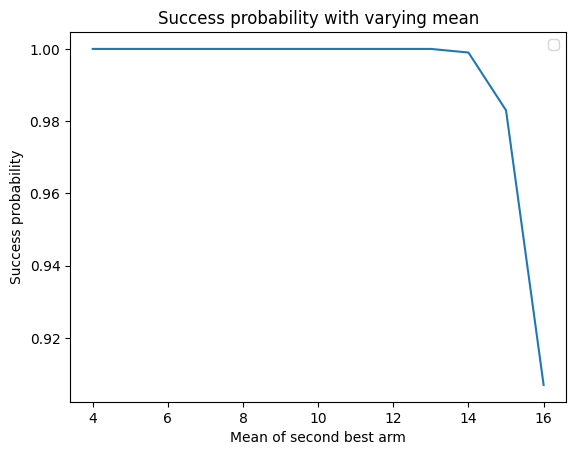

In [23]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct)
plt.legend()
plt.show()

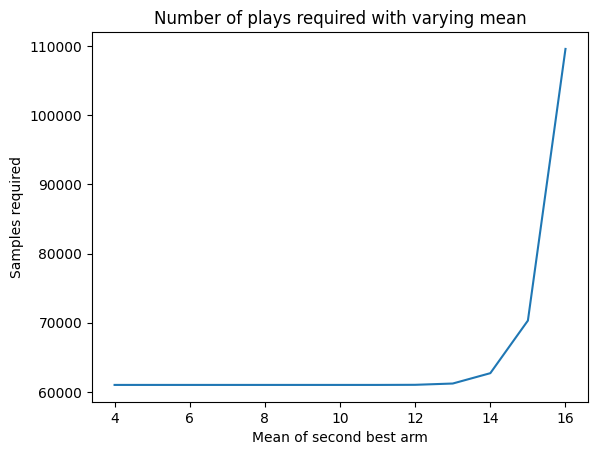

In [24]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, sample_req)
plt.show()

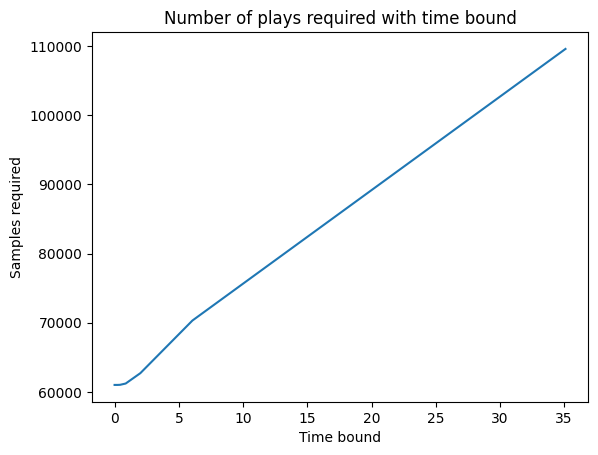

In [25]:
plt.title("Number of plays required with time bound")
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.plot(time_bound, sample_req)
plt.show()

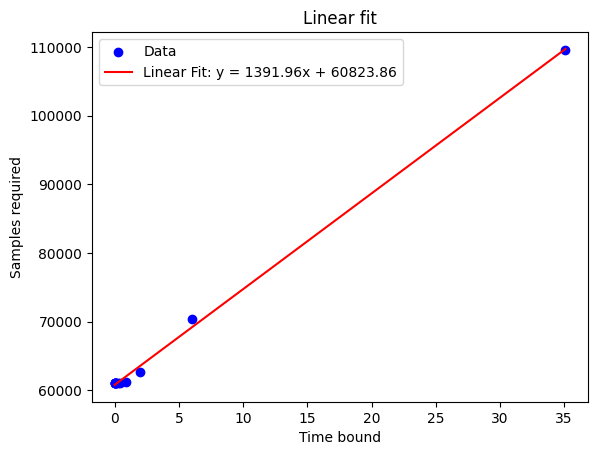

In [26]:
slope, intercept = np.polyfit(time_bound, sample_req, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, sample_req, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

#### Best and second best arm (arm 0 and arm 1) have same total mean, one of them (arm 0) violates the threshold, we will take one attribute of arm 0 closer to the threshold and compare the results

[10, 20], [x, 30-x], [10, 10], threshold = 7, x varies from 1 to 7, var = 4

In [408]:
# # #### Values #####
#         self.var = 4
#         self.mu_ij[0] = np.array([20, 10])
#         self.mu_ij[1] = np.array([x, 30-x])
#         self.mu_ij[2] = np.array([10, 10])
#         self.mu_ij[3] = np.array([4, 8])
#         self.mu_ij[4] = np.array([1, 7])

In [29]:
N = 3
M = 2
x = 1
N_iter = 1000

prob_correct = []
prob_infeasible = []
sample_req = []
x_val = []
time_bound = []

while(x < 7):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    time_bound_temp = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=7)
        upper_bound = h_idx * math.log(h_idx/delta)
        time_bound_temp.append(upper_bound)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)

    time_bound.append(sum(time_bound_temp)/N_iter)
    print("time: ", h_idx)

    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct.append(prob0)
    prob_infeasible.append(probN)
    sample_req.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct)
print(prob_infeasible)

C:\Users\saksh\AppData\Local\Temp\ipykernel_6620\3606964609.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  h0 = 1/h0_den


time:  inf
1.0
time:  inf
1.0
time:  inf
1.0
time:  inf
1.0
time:  inf
1.0
time:  inf
0.971
[1.0, 1.0, 1.0, 1.0, 1.0, 0.971]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


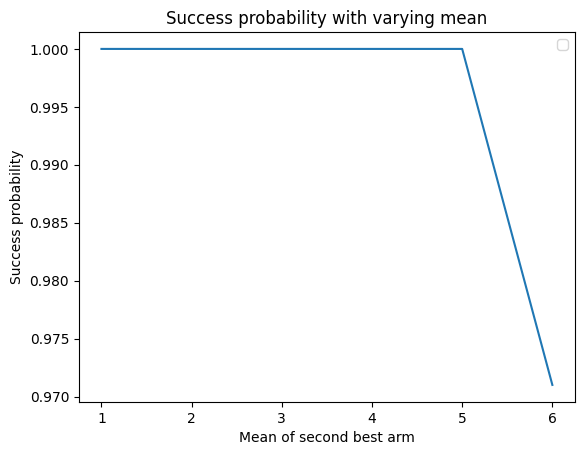

In [30]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct)
plt.legend()
plt.show()

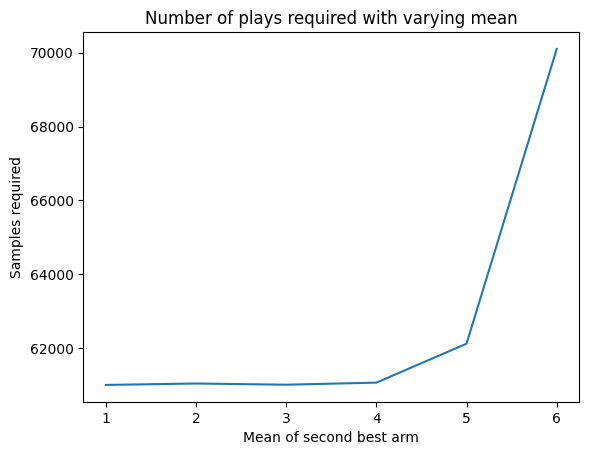

In [31]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, sample_req)
plt.show()

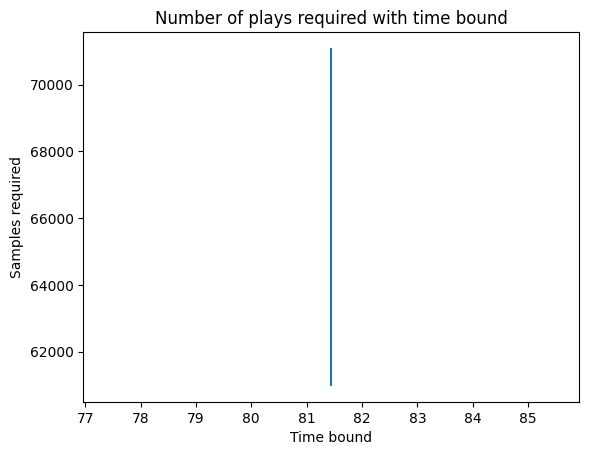

In [414]:
plt.title("Number of plays required with time bound")
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.plot(time_bound, sample_req)
plt.show()

In [ ]:
slope, intercept = np.polyfit(time_bound, sample_req, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, sample_req, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

#### Arm 1 violates the threshold but it has the maximum mean. Arm 0 has 2nd maximum mean but both the arms are valid. We will increase the mean of this arm to that of arm 0 and check the probability of success (predicting arm 0)

Threshold = 6

In [ ]:
# # #### Values #####
#         self.var = 3
#         self.mu_ij[0] = np.array([x, 8])          #16 to 24
#         self.mu_ij[1] = np.array([4, 17])         #21
#         self.mu_ij[2] = np.array([7, 8])          #15
#         self.mu_ij[3] = np.array([4, 8])          #12
#         self.mu_ij[4] = np.array([1, 7])          #8

In [33]:
N = 3
M = 2
x = 8
N_iter = 1000

prob_correct = []
prob_infeasible = []
sample_req = []
x_val = []
time_bound = []

while(x < 16):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    time_bound_temp = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=6)
        upper_bound = h_idx * math.log(h_idx/delta)
        time_bound_temp.append(upper_bound)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)

    time_bound.append(sum(time_bound_temp)/N_iter)

    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct.append(prob0)
    prob_infeasible.append(probN)
    sample_req.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct)
print(prob_infeasible)

0.937
0.99
1.0
1.0
1.0


C:\Users\saksh\AppData\Local\Temp\ipykernel_6620\525639473.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  h0 = 1/h0_den


1.0
1.0
1.0
[0.937, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


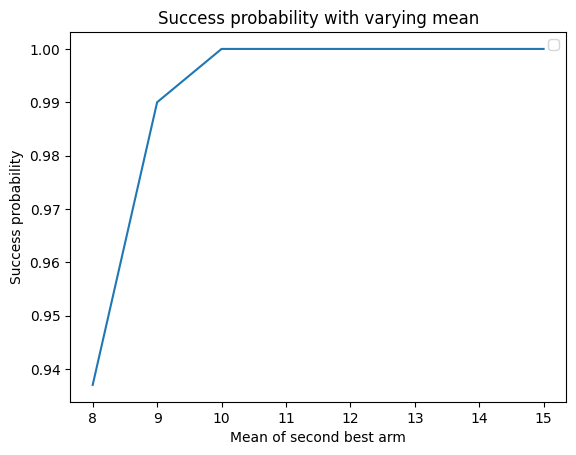

In [35]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct)
plt.legend()
plt.show()

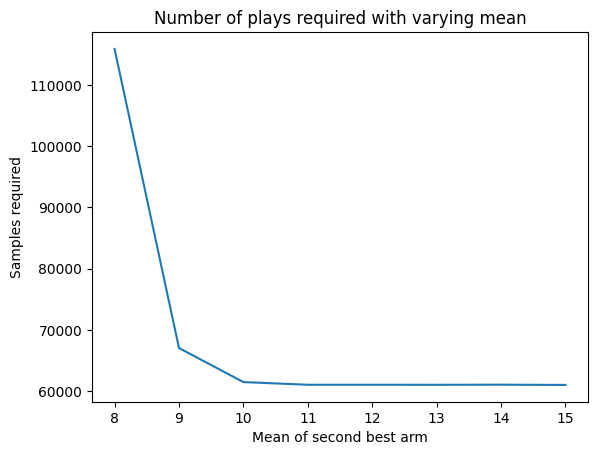

In [422]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, sample_req)
plt.show()

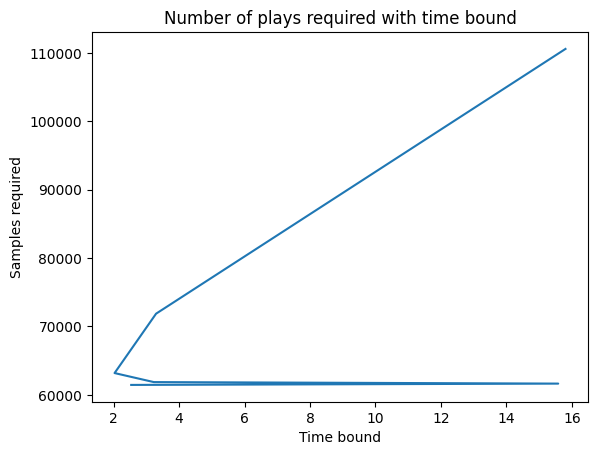

[15.80487012372443, 3.298823231664274, 2.030942573004041, 3.2292801491165384, 15.582802568100396, 2.5387375023919962]


In [41]:
time_bound.pop(5)
sample_req.pop(5)
plt.title("Number of plays required with time bound")
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.plot(time_bound, sample_req)
plt.show()
print(time_bound)

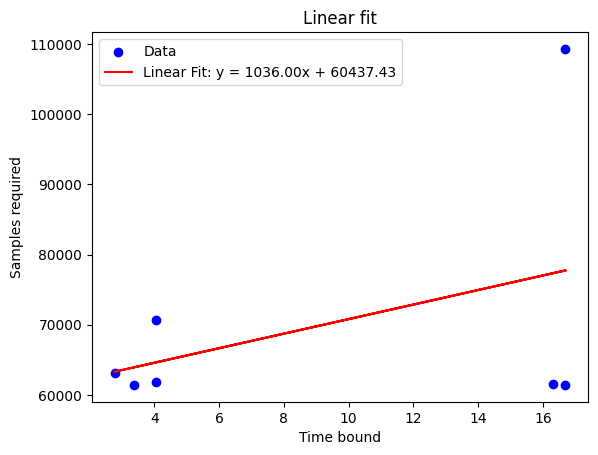

In [36]:
time_bound.pop(5)
sample_req.pop(5)
slope, intercept = np.polyfit(time_bound, sample_req, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, sample_req, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

## Case with 3 to 5 arms

####  Best 2 arms are valid

In [244]:
# self.var = 3
#         self.mu_ij[0] = np.array([8, 7])
#         self.mu_ij[1] = np.array([8, 6])
#         self.mu_ij[2] = np.array([5, 6])
#         self.mu_ij[3] = np.array([4, 8])
#         self.mu_ij[4] = np.array([1, 7])

N = 3
M = 2
best_arm_identified_3 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=2)
    # print(best_arm_guess)
    best_arm_identified_3.append(best_arm_guess)
prob0 = best_arm_identified_3.count(0)/N_iter
prob1 = best_arm_identified_3.count(1)/N_iter
prob2 = best_arm_identified_3.count(2)/N_iter
prob_infeasible = best_arm_identified_3.count(N)/N_iter
print(prob0, prob1, prob2)
print(prob_infeasible)


N = 4
best_arm_identified_4 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=2)
    best_arm_identified_4.append(best_arm_guess)
prob0 = best_arm_identified_4.count(0)/N_iter
prob1 = best_arm_identified_4.count(1)/N_iter
prob2 = best_arm_identified_4.count(2)/N_iter
prob_infeasible = best_arm_identified_3.count(N)/N_iter
print(prob0, prob1, prob2)
print(prob_infeasible)


N = 5
best_arm_identified_5 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=2)
    best_arm_identified_5.append(best_arm_guess)
prob0 = best_arm_identified_5.count(0)/N_iter
prob1 = best_arm_identified_5.count(1)/N_iter
prob2 = best_arm_identified_5.count(2)/N_iter
prob_infeasible = best_arm_identified_3.count(N)/N_iter
print(prob0, prob1, prob2)
print(prob_infeasible)

# best_arm_identified, samples = game()
# print(best_arm_identified)

0.933 0.067 0.0
0.0
0.938 0.062 0.0
0.0
0.932 0.068 0.0
0.0


#### Case 2

In [242]:
# self.var = 3
#         self.mu_ij[0] = np.array([8, 7])      15
#         self.mu_ij[1] = np.array([4, 6])      10
#         self.mu_ij[2] = np.array([11, 4])     15
#         self.mu_ij[3] = np.array([4, 8])      12
#         self.mu_ij[4] = np.array([1, 7])      8

N = 3
M = 2
best_arm_identified_3 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=6)
    # print(best_arm_guess)
    best_arm_identified_3.append(best_arm_guess)
prob0 = best_arm_identified_3.count(0)/N_iter
prob1 = best_arm_identified_3.count(1)/N_iter
prob2 = best_arm_identified_3.count(2)/N_iter
prob_infeasible = best_arm_identified_3.count(N)/N_iter
print(prob0, prob1, prob2)
print(prob_infeasible)


N = 4
best_arm_identified_4 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=6)
    best_arm_identified_4.append(best_arm_guess)
prob0 = best_arm_identified_4.count(0)/N_iter
prob1 = best_arm_identified_4.count(1)/N_iter
prob2 = best_arm_identified_4.count(2)/N_iter
prob_infeasible = best_arm_identified_3.count(N)/N_iter
print(prob0, prob1, prob2)
print(prob_infeasible)


N = 5
best_arm_identified_5 = []
N_iter = 1000
for i in range (N_iter):
    best_arm_guess, f, samples = game(M, N, mu_th=6)
    best_arm_identified_5.append(best_arm_guess)
prob0 = best_arm_identified_5.count(0)/N_iter
prob1 = best_arm_identified_5.count(1)/N_iter
prob2 = best_arm_identified_5.count(2)/N_iter
prob_infeasible = best_arm_identified_3.count(N)/N_iter
print(prob0, prob1, prob2)
print(prob_infeasible)

# best_arm_identified, samples = game()
# print(best_arm_identified)

0.99 0.0 0.0
0.01
0.989 0.0 0.0
0.0
0.989 0.0 0.0
0.0


#### Case: all arms valid, taking mean of one arm closer to the next arm

In [ ]:
# self.var = 3
#         self.mu_ij[0] = np.array([20, 10])
#         self.mu_ij[1] = np.array([x, 13])
#         self.mu_ij[2] = np.array([5, 6])
#         self.mu_ij[3] = np.array([17, 8])
#         self.mu_ij[4] = np.array([9, 11])

In [252]:
N = 3
M = 2
x = 4
N_iter = 1000

prob_correct_3 = []
prob_infeasible_3 = []
sample_req_3 = []
x_val = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, f, samples = game(M, N, mu_th=2)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_3.append(prob0)
    prob_infeasible_3.append(probN)
    sample_req_3.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct_3)
print(prob_infeasible_3)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999
0.994
0.919
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.994, 0.919]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [253]:
N = 4
M = 2
x = 4
N_iter = 1000

prob_correct_4 = []
prob_giveup_4 = []
sample_req_4 = []
x_val = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, f, samples = game(M, N, mu_th=2)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_4.append(prob0)
    prob_giveup_4.append(probN)
    sample_req_4.append(samp_avg)

    x += 1

print(prob_correct_4)
print(prob_giveup_4)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.992, 0.925]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [254]:
N = 5
M = 2
x = 4
N_iter = 1000

prob_correct_5 = []
prob_giveup_5 = []
sample_req_5 = []
x_val = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, f, samples = game(M, N, mu_th=2)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_5.append(prob0)
    prob_giveup_5.append(probN)
    sample_req_5.append(samp_avg)

    x += 1

print(prob_correct_5)
print(prob_giveup_5)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994, 0.929]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


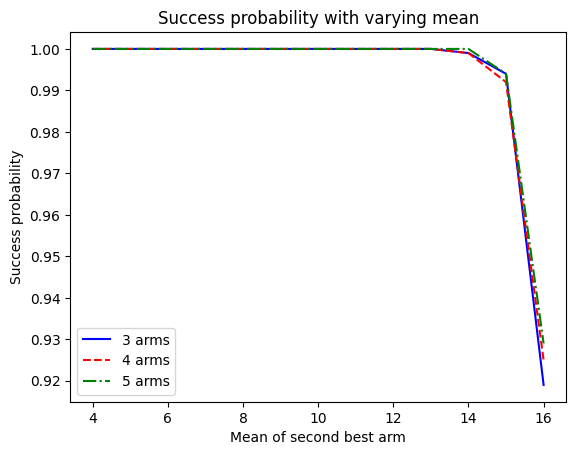

In [256]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, prob_correct_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, prob_correct_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

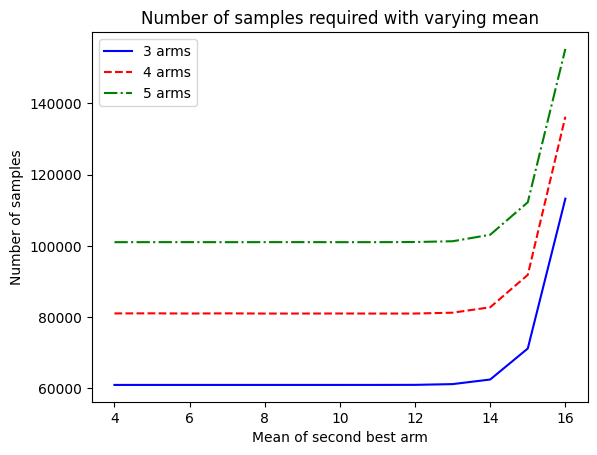

In [255]:
plt.title("Number of samples required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Number of samples")
plt.plot(x_val, sample_req_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, sample_req_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, sample_req_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

H index

In [18]:
N = 3
M = 2
x = 4
N_iter = 1000

prob_correct_3 = []
prob_infeasible_3 = []
sample_req_3 = []
x_val = []
time_bound_3 = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    time_bound_temp = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=2)
        upper_bound = h_idx * math.log(h_idx/delta)
        time_bound_temp.append(upper_bound)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)

    time_bound_3.append(sum(time_bound_temp)/N_iter)

    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_3.append(prob0)
    prob_infeasible_3.append(probN)
    sample_req_3.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct_3)
print(prob_infeasible_3)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999
1.0
0.984
0.941
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 0.984, 0.941]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


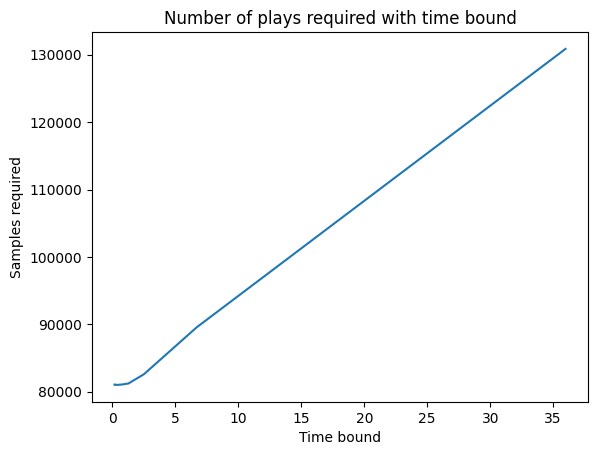

In [23]:
plt.title("Number of plays required with time bound")
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.plot(time_bound_3, sample_req_3)
plt.show()

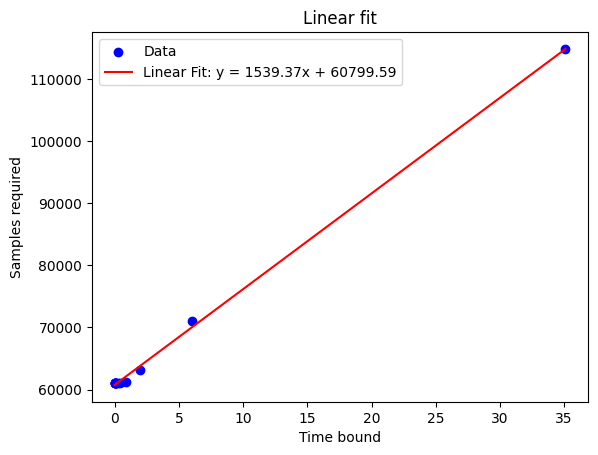

In [26]:
slope, intercept = np.polyfit(time_bound, sample_req, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, sample_req, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

In [21]:
N = 4
M = 2
x = 4
N_iter = 1000

prob_correct_4 = []
prob_infeasible_4 = []
sample_req_4 = []
x_val = []
time_bound_4 = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    time_bound_temp = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=2)
        upper_bound = h_idx * math.log(h_idx/delta)
        time_bound_temp.append(upper_bound)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)

    time_bound_4.append(sum(time_bound_temp)/N_iter)

    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_4.append(prob0)
    prob_infeasible_4.append(probN)
    sample_req_4.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct_4)
print(prob_infeasible_4)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.993
0.919
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.993, 0.919]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


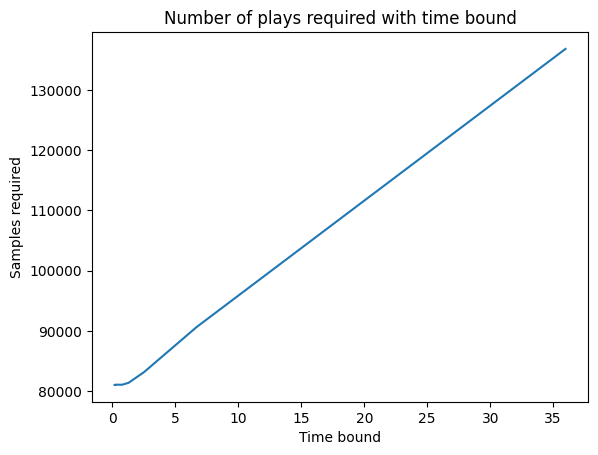

In [24]:
plt.title("Number of plays required with time bound")
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.plot(time_bound_4, sample_req_4)
plt.show()

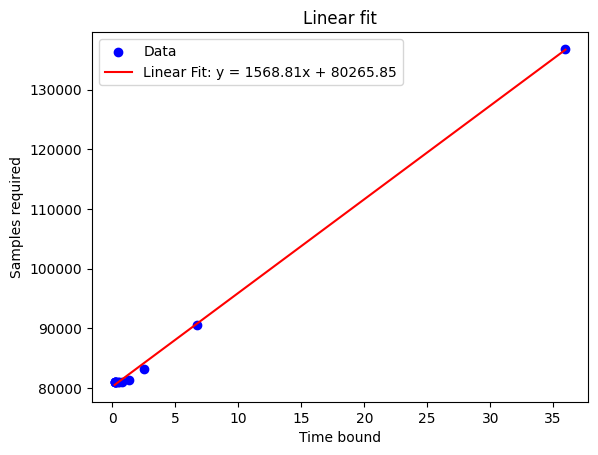

In [27]:
slope, intercept = np.polyfit(time_bound_4, sample_req_4, 1)
time_bound_arr_4 = np.array(time_bound_4)
regression_line = slope * time_bound_arr_4 + intercept
plt.scatter(time_bound_4, sample_req_4, label='Data', color='blue')
plt.plot(time_bound_arr_4, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

In [20]:
N = 5
M = 2
x = 4
N_iter = 1000

prob_correct_5 = []
prob_infeasible_5 = []
sample_req_5 = []
x_val = []
time_bound_5 = []

while(x < 17):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    time_bound_temp = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=2)
        upper_bound = h_idx * math.log(h_idx/delta)
        time_bound_temp.append(upper_bound)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)

    time_bound_5.append(sum(time_bound_temp)/N_iter)

    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_5.append(prob0)
    prob_infeasible_5.append(probN)
    sample_req_5.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct_5)
print(prob_infeasible_5)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.998
0.989
0.939
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998, 0.989, 0.939]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


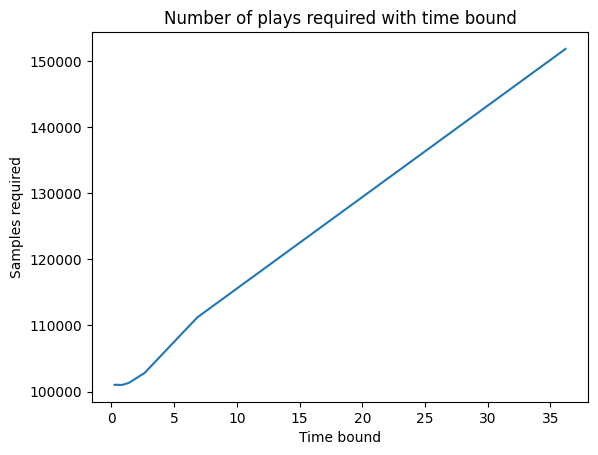

In [25]:
plt.title("Number of plays required with time bound")
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.plot(time_bound_5, sample_req_5)
plt.show()

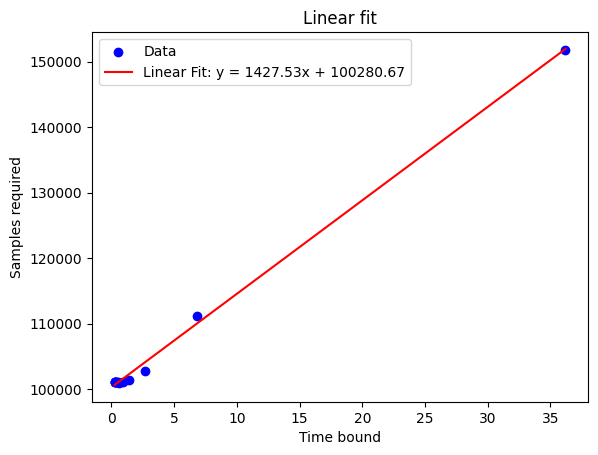

In [28]:
slope, intercept = np.polyfit(time_bound_5, sample_req_5, 1)
time_bound_arr = np.array(time_bound_5)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound_5, sample_req_5, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

#### 2 arms with same mean, but one of them violates threshold

In [ ]:
# self.var = 4
#         self.mu_ij[0] = np.array([20, 10])
#         self.mu_ij[1] = np.array([x, 30-x])
#         self.mu_ij[2] = np.array([10, 10])
#         self.mu_ij[3] = np.array([5, 20])
#         self.mu_ij[4] = np.array([7, 15])

In [261]:
N = 3
M = 2
x = 1
N_iter = 1000

prob_correct_3 = []
prob_infeasible_3 = []
sample_req_3 = []
x_val = []

while(x < 7):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, f, samples = game(M, N, mu_th=7)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_3.append(prob0)
    prob_infeasible_3.append(probN)
    sample_req_3.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct_3)
print(prob_infeasible_3)

1.0
1.0
1.0
1.0
0.998
0.965
[1.0, 1.0, 1.0, 1.0, 0.998, 0.965]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [262]:
N = 4
M = 2
x = 1
N_iter = 1000

prob_correct_4 = []
prob_giveup_4 = []
sample_req_4 = []
x_val = []

while(x < 7):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, f, samples = game(M, N, mu_th=7)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_4.append(prob0)
    prob_giveup_4.append(probN)
    sample_req_4.append(samp_avg)

    x += 1

print(prob_correct_4)
print(prob_giveup_4)

[1.0, 1.0, 1.0, 1.0, 0.998, 0.966]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [263]:
N = 5
M = 2
x = 1
N_iter = 1000

prob_correct_5 = []
prob_giveup_5 = []
sample_req_5 = []
x_val = []

while(x < 7):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, f, samples = game(M, N, mu_th=7)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_5.append(prob0)
    prob_giveup_5.append(probN)
    sample_req_5.append(samp_avg)

    x += 1

print(prob_correct_5)
print(prob_giveup_5)

[1.0, 1.0, 1.0, 1.0, 0.998, 0.955]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


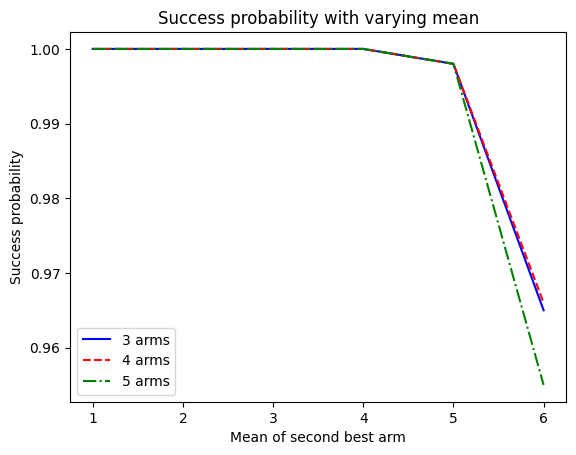

In [264]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, prob_correct_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, prob_correct_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

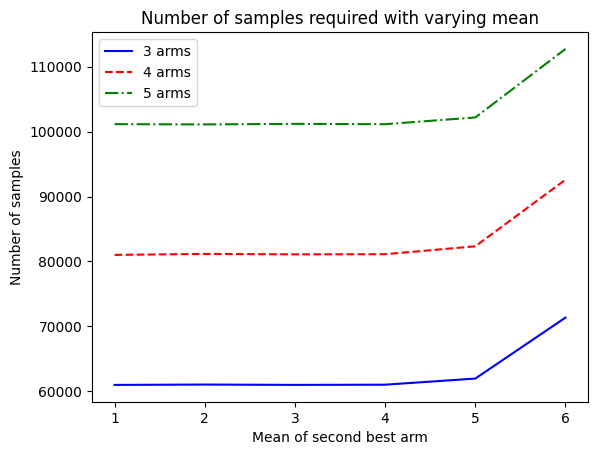

In [265]:
plt.title("Number of samples required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Number of samples")
plt.plot(x_val, sample_req_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, sample_req_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, sample_req_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

#### Max mean arm violates the threshold, arm with 2nd max mean is valid

In [266]:
# self.var = 2
#         self.mu_ij[0] = np.array([x, 8])      #16 to 24
#         self.mu_ij[1] = np.array([5, 16])     #21
#         self.mu_ij[2] = np.array([7, 8])      #15
#         self.mu_ij[3] = np.array([5, 10])     #15
#         self.mu_ij[4] = np.array([6, 8])     #15

In [289]:
N = 3
M = 2
x = 8
N_iter = 1000

prob_correct_3 = []
prob_infeasible_3 = []
sample_req_3 = []
x_val = []

while(x < 16):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, f, samples = game(M, N, mu_th=6)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_3.append(prob0)
    prob_infeasible_3.append(probN)
    sample_req_3.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct_3)
print(prob_infeasible_3)

0.913
0.978
0.989
0.988
0.992
0.998
0.993
0.999
[0.913, 0.978, 0.989, 0.988, 0.992, 0.998, 0.993, 0.999]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [290]:
N = 4
M = 2
x = 8
N_iter = 1000

prob_correct_4 = []
prob_giveup_4 = []
sample_req_4 = []
x_val = []

while(x < 16):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, f, samples = game(M, N, mu_th=6)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_4.append(prob0)
    prob_giveup_4.append(probN)
    sample_req_4.append(samp_avg)

    x += 1

print(prob_correct_4)
print(prob_giveup_4)

[0.925, 0.983, 0.988, 0.992, 0.992, 0.99, 0.996, 0.999]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [291]:
N = 5
M = 2
x = 8
N_iter = 1000

prob_correct_5 = []
prob_giveup_5 = []
sample_req_5 = []
x_val = []

while(x < 16):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    for i in range (N_iter):
        best_arm_guess, f, samples = game(M, N, mu_th=6)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)
    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)

    prob_correct_5.append(prob0)
    prob_giveup_5.append(probN)
    sample_req_5.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct_5)
print(prob_giveup_5)

0.924
0.985
0.996
0.993
0.994
0.993
1.0
1.0
[0.924, 0.985, 0.996, 0.993, 0.994, 0.993, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


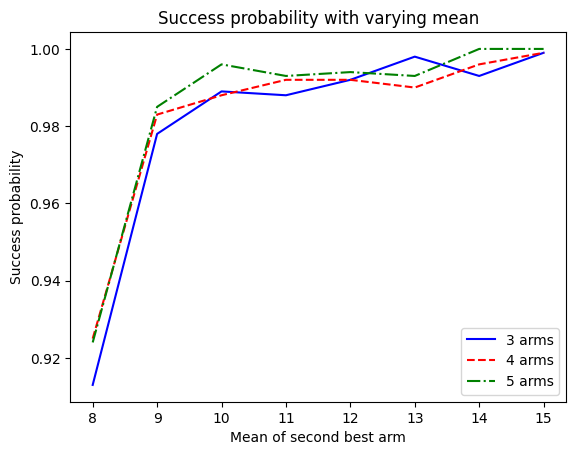

In [292]:
plt.title("Success probability with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Success probability")
plt.plot(x_val, prob_correct_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, prob_correct_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, prob_correct_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

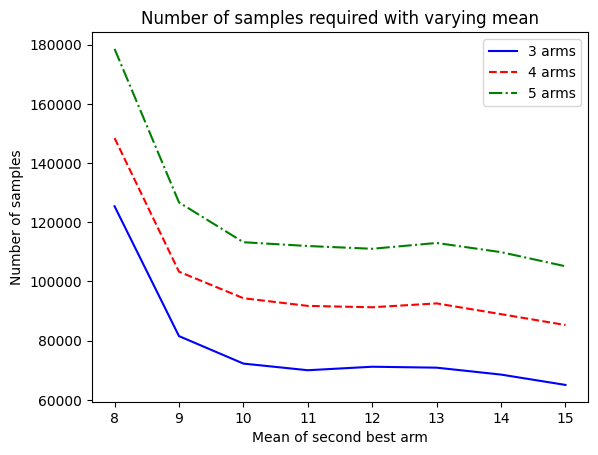

In [293]:
plt.title("Number of samples required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Number of samples")
plt.plot(x_val, sample_req_3, label='3 arms', linestyle='-', color='blue')

# Plot the second graph
plt.plot(x_val, sample_req_4, label='4 arms', linestyle='--', color='red')

# Plot the third graph
plt.plot(x_val, sample_req_5, label='5 arms', linestyle='-.', color='green')
plt.legend()
plt.show()

## Use of H-index

#### Case 1a

In [ ]:
# self.var = 2
#         self.mu_ij[0] = np.array([x, 6])          #22 to 32
#         self.mu_ij[1] = np.array([4, 17])         #21
#         self.mu_ij[2] = np.array([7, 8])          #15
#         self.mu_ij[3] = np.array([4, 8])          #12
#         self.mu_ij[4] = np.array([1, 7])          #8

# mu_th = 6
# self.delta_i[self.i_star]/2 < self.delta_i_attr[self.i_star]
# delta_i varies from 3 to 9
# delta_i_attr greater
# x varies from 14 to 24

In [63]:
N = 5
M = 2
x = 16
N_iter = 1000

prob_correct = []
prob_infeasible = []
sample_req = []
x_val = []
time_bound = []

while(x < 25):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    time_bound_temp = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=6)
        upper_bound = h_idx * math.log(h_idx/delta)*1000
        time_bound_temp.append(upper_bound)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)

    time_bound.append(sum(time_bound_temp)/N_iter)

    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)


    prob_correct.append(prob0)
    prob_infeasible.append(probN)
    sample_req.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct)
print(prob_infeasible)
print(time_bound)
print(sample_req)

Feasible:  [0, 2] Perfect feasible:  [0] Potential:  [] mu_hat for all [23.62505356870835, 21.968994079571146, 13.723284729314262, 12.198712893292107, 7.588168880080517] UCB of all:  [24.384422587258506, 22.728363098121303, 14.482653747864418, 12.958081911842264, 8.347537898630675]
Feasible:  [0, 2] Perfect feasible:  [0, 2] Potential:  [] mu_hat for all [23.387855485828894, 20.746814471156043, 15.182564643718518, 12.151967691840431, 9.277169666193641] UCB of all:  [24.14722450437905, 21.5061834897062, 15.941933662268674, 12.911336710390588, 10.036538684743798]
Feasible:  [0, 2] Perfect feasible:  [0, 2] Potential:  [1] mu_hat for all [23.41540513132764, 22.218589747647126, 15.40263806009401, 11.948229368125059, 8.655718312080426] UCB of all:  [24.174774149877795, 22.977958766197283, 16.162007078644166, 12.707598386675215, 9.415087330630582]
Feasible:  [0, 1, 2] Perfect feasible:  [0, 2] Potential:  [] mu_hat for all [24.81259122564287, 21.811212288398295, 15.564430270094507, 12.089345

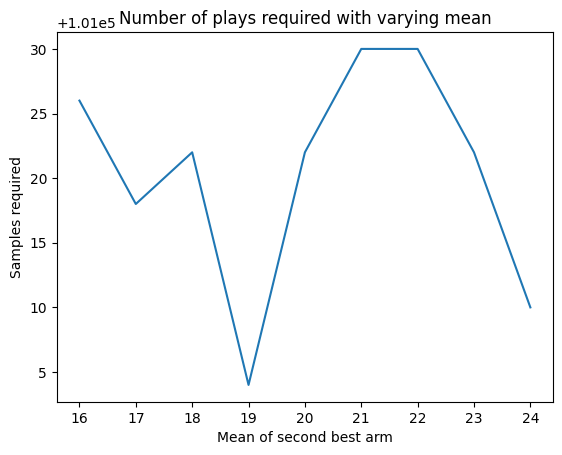

In [64]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, sample_req)
plt.show()

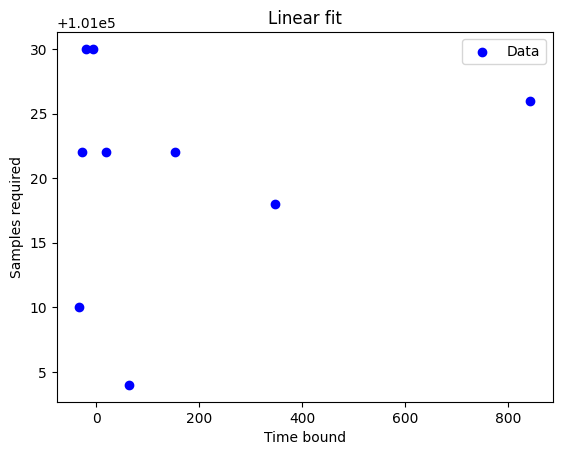

In [65]:
slope, intercept = np.polyfit(time_bound, sample_req, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, sample_req, label='Data', color='blue')
# plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

#### Case 1b

In [ ]:
# self.var = 2
#         self.mu_ij[0] = np.array([x, 31-x])       #31
#         self.mu_ij[1] = np.array([4, 17])         #21
#         self.mu_ij[2] = np.array([7, 8])          #15
#         self.mu_ij[3] = np.array([4, 8])          #12
#         self.mu_ij[4] = np.array([1, 7])          #8

# mu_th = 6
# self.delta_i[self.i_star]/2 > self.delta_i_attr[self.i_star]
# delta_i is 10
# delta_i_attr 25 - 2*th
# x varies from 14 to 24
# Basic problem to be addressed is feasibility

In [67]:
N = 5
M = 2
x = 16
N_iter = 1000

prob_correct = []
prob_infeasible = []
sample_req = []
x_val = []
time_bound = []

while(x < 25):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    time_bound_temp = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=6)
        upper_bound = h_idx * math.log(h_idx/delta)*1000
        time_bound_temp.append(upper_bound)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)

    time_bound.append(sum(time_bound_temp)/N_iter)

    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)


    prob_correct.append(prob0)
    prob_infeasible.append(probN)
    sample_req.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct)
print(prob_infeasible)
print(time_bound)
print(sample_req)

Feasible:  [0, 2] Perfect feasible:  [0, 2] Potential:  [] mu_hat for all [30.31588637733269, 21.40348311809906, 16.483148123061163, 11.641824414410197, 7.261226111062652] UCB of all:  [31.075255395882845, 22.162852136649217, 17.24251714161132, 12.401193432960353, 8.02059512961281]
Feasible:  [0, 2] Perfect feasible:  [0] Potential:  [] mu_hat for all [31.2707492999224, 20.461832290273705, 14.246368619159622, 12.840713022477754, 7.849607272364778] UCB of all:  [32.03011831847256, 21.22120130882386, 15.005737637709778, 13.60008204102791, 8.608976290914935]
Feasible:  [0, 2] Perfect feasible:  [0, 2] Potential:  [] mu_hat for all [29.75264044773624, 20.31507702612429, 14.669650936143949, 12.067970048678632, 8.21605788435445] UCB of all:  [30.512009466286397, 21.074446044674445, 15.429019954694105, 12.827339067228788, 8.975426902904607]
Feasible:  [0, 2] Perfect feasible:  [0, 2] Potential:  [] mu_hat for all [30.850953938614573, 21.078173441438224, 15.234573936834877, 11.654901637300167,

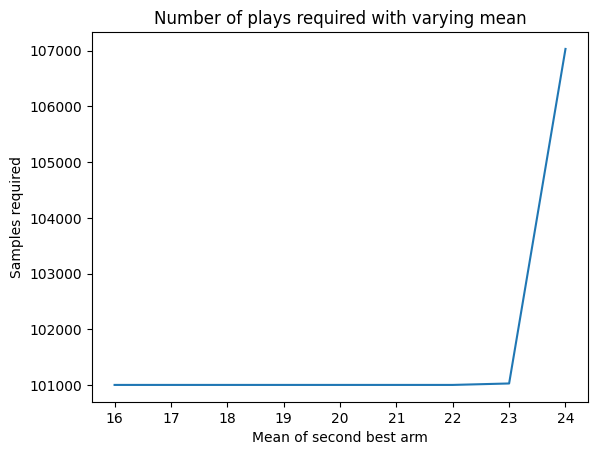

In [68]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, sample_req)
plt.show()

C:\Users\saksh\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


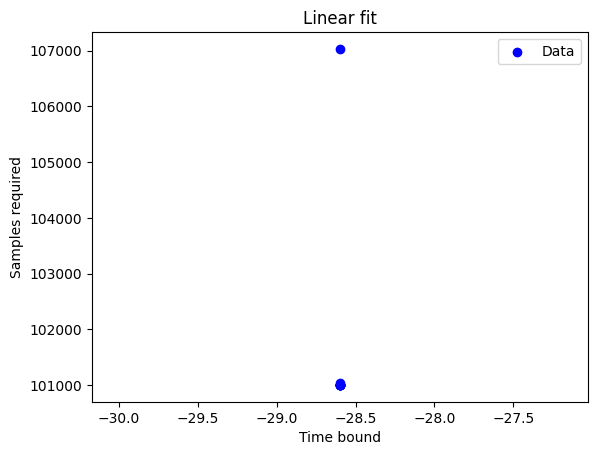

In [69]:
slope, intercept = np.polyfit(time_bound, sample_req, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, sample_req, label='Data', color='blue')
# plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

This happened because the value of h ind remained constant throughout

#### Case 1b again

In [ ]:
# self.var = 2
#         self.mu_ij[0] = np.array([x, 36-2x])      #36-x
#         self.mu_ij[1] = np.array([4, 17])         #21
#         self.mu_ij[2] = np.array([7, 8])          #15
#         self.mu_ij[3] = np.array([4, 8])          #12
#         self.mu_ij[4] = np.array([1, 7])          #8

# mu_th = 6
# self.delta_i[self.i_star]/2 > self.delta_i_attr[self.i_star]
# delta_i is 15-x
# delta_i_attr 25 - 2*th - x
# x varies from 14 to 24
# Basic problem to be addressed is feasibility

In [21]:
N = 5
M = 2
x = 7
N_iter = 1000

prob_correct = []
prob_infeasible = []
sample_req = []
x_val = []
time_bound = []

while(x < 11):
    x_val.append(x)
    sample_iter = []
    best_arm_identified = []
    time_bound_temp = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=6)
        upper_bound = h_idx * math.log(h_idx/delta)*1000
        time_bound_temp.append(upper_bound)
        best_arm_identified.append(best_arm_guess)
        sample_iter.append(samples)

    time_bound.append(sum(time_bound_temp)/N_iter)

    prob0 = best_arm_identified.count(0)/N_iter
    probN = best_arm_identified.count(N)/N_iter
    # print(prob0)
    samp_avg = sum(sample_iter)


    prob_correct.append(prob0)
    prob_infeasible.append(probN)
    sample_req.append(samp_avg)
    print(prob0)

    x += 1

print(prob_correct)
print(prob_infeasible)
print(time_bound)
print(sample_req)

1.0
1.0
1.0
1.0
[1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0]
[-6.4807978287080195, 18.392629128827465, 63.95940222578642, 152.9633764930892]
[108128, 101016, 101000, 101000]


In [18]:
print(sample_req)
x_val.pop(5)

[104788, 104694, 104864, 104368, 109758]


6

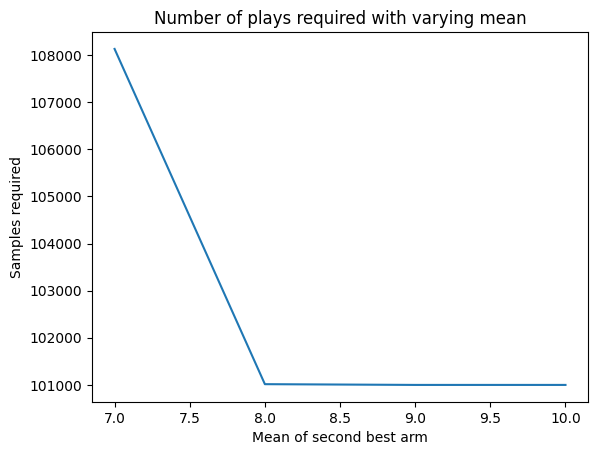

In [22]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, sample_req)
plt.show()

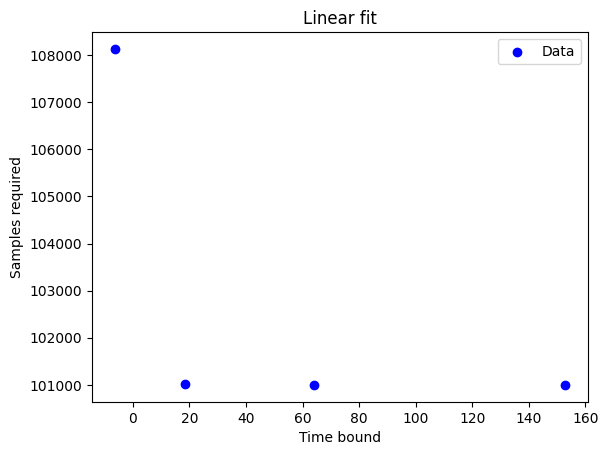

In [23]:
slope, intercept = np.polyfit(time_bound, sample_req, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, sample_req, label='Data', color='blue')
# plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

In [84]:
import numpy as np

def initialization(N, test, instance, trial):
    np.random.seed(trial + 20)  # For reproducibility
    j = instance
    switcher = {
        1: (0.7, 0.01 * 1.2 ** j, 0.09, 0.2, 0.09),
        2: (0.55, 0.02, 0.25 - 0.01 * 1.2 ** j, 0.15, 0.09),
        3: (0.55, 0.4, 0.25 - 0.01 * 1.2 ** j, 0.15, 0.09),
        4: (0.7, 0.02 * 1.1 ** j, 0.03, 0.3, 0.03),
        5: (0.7, 0.02 * 1.2 ** j, 0.09, 0.7 - 0.02 * 1.2 ** j, 0.09),
        6: (0.55, 0.04 + 0.01 * 1.2 ** j),
        7: (0.7, 0.02 * 1.2 ** j, 0.03, 0.53, 0.2),
        8: (0.55, 0.02, 0.03, 0.53, 0.04 + 0.05 * 1.1 ** j),
        9: (0.7, 0.09 * 1.1 ** j, 0.04, 0.7 - 0.09 * 1.1 ** j, 0.21),
        10: (0.7, 0.4, 0.03, 0.3, 0.04 + 0.01 * 1.2 ** j)
    }

    a, delta_istar, b, a1, b1 = switcher.get(test, (0, 0, 0, 0, 0))
    mean_variance = [(a, b), (a1, b1)]

    for _ in range(N - 2):
        mean_variance.append((0.2, 0.09))

    bar = 0.25 if test in [1, 2, 3, 5] else 0.04

    # Compute the parameters for beta distribution
    para = bpara(np.array(mean_variance)[:, 0], np.array(mean_variance)[:, 1])
    alpha = para[:, 0]
    beta = para[:, 1]
    expec = alpha / (alpha + beta)
    variance = (alpha * beta) / ((alpha + beta) ** 2 * (alpha + beta + 1))

    return para, expec, variance, bar

def bpara(mean, var):
    alpha = ((1 - mean) / var - 1 / mean) * mean ** 2
    beta = alpha * (1 / mean - 1)
    return np.vstack((alpha, beta)).T

N = 10  # Example value for the number of arms
test = 1  # Example value for the test term index
instance = 1  # Example value for the instance
trial = 1  # Example value for the trial

para, expec, variance, bar = initialization(N, test, instance, trial)

print("Parameters (Alpha and Beta):", para)
print("Expectations:", expec)
print("Variances:", variance)
print("Bar:", bar)


Parameters (Alpha and Beta): [[0.93333333 0.4       ]
 [0.15555556 0.62222222]
 [0.15555556 0.62222222]
 [0.15555556 0.62222222]
 [0.15555556 0.62222222]
 [0.15555556 0.62222222]
 [0.15555556 0.62222222]
 [0.15555556 0.62222222]
 [0.15555556 0.62222222]
 [0.15555556 0.62222222]]
Expectations: [0.7 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Variances: [0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09]
Bar: 0.25
